In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
tf.compat.v1.disable_eager_execution()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-04,1308.229980,1327.660034,1299.000000,1326.800049,1326.800049,1504000
1,2020-05-05,1337.920044,1373.939941,1337.459961,1351.109985,1351.109985,1651500
2,2020-05-06,1361.689941,1371.119995,1347.290039,1347.300049,1347.300049,1215400
3,2020-05-07,1365.939941,1377.599976,1355.270020,1372.560059,1372.560059,1397600
4,2020-05-08,1383.130005,1398.760010,1375.479980,1388.369995,1388.369995,1386900


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.compat.v1.placeholder(tf.float32, (None))
        self.ACTIONS = tf.compat.v1.placeholder(tf.int32, (None))
        feed_forward = tf.compat.v1.layers.dense(self.X, self.LAYER_SIZE, activation = tf.compat.v1.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.compat.v1.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.compat.v1.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 5315.434326.3, cost: -2009.030884, total money: 15315.434326
epoch: 20, total rewards: 4789.463992.3, cost: -2796.204590, total money: 14789.463992
epoch: 30, total rewards: 5801.174194.3, cost: -1836.356323, total money: 15801.174194
epoch: 40, total rewards: 5203.644656.3, cost: -2260.210449, total money: 15203.644656
epoch: 50, total rewards: 5756.119386.3, cost: -3399.217041, total money: 15756.119386
epoch: 60, total rewards: 5805.754276.3, cost: -2249.633545, total money: 15805.754276
epoch: 70, total rewards: 5826.279177.3, cost: -2141.062500, total money: 15826.279177
epoch: 80, total rewards: 5789.219120.3, cost: -2143.959961, total money: 15789.219120
epoch: 90, total rewards: 5314.364139.3, cost: -2501.715576, total money: 15314.364139
epoch: 100, total rewards: 4755.048953.3, cost: -2493.698730, total money: 14755.048953

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 1326.800049, total balance 8673.199951
day 1, sell 1 unit at price 1351.109985, investment 1.832223 %, total balance 10024.309936,
day 2: buy 1 unit at price 1347.300049, total balance 8677.009887
day 3: buy 1 unit at price 1372.560059, total balance 7304.449828
day 4: buy 1 unit at price 1388.369995, total balance 5916.079833
day 5: buy 1 unit at price 1403.260010, total balance 4512.819823
day 6: buy 1 unit at price 1375.739990, total balance 3137.079833
day 7: buy 1 unit at price 1349.329956, total balance 1787.749877
day 8, sell 1 unit at price 1356.130005, investment 0.655382 %, total balance 3143.879882,
day 9: buy 1 unit at price 1373.189941, total balance 1770.689941
day 10: buy 1 unit at price 1383.939941, total balance 386.750000
day 15, sell 1 unit at price 1417.020020, investment 3.239200 %, total balance 1803.770020,
day 16: buy 1 unit at price 1417.839966, total balance 385.930054
day 26, sell 1 unit at price 1465.849976, investment 5.580644 %, 

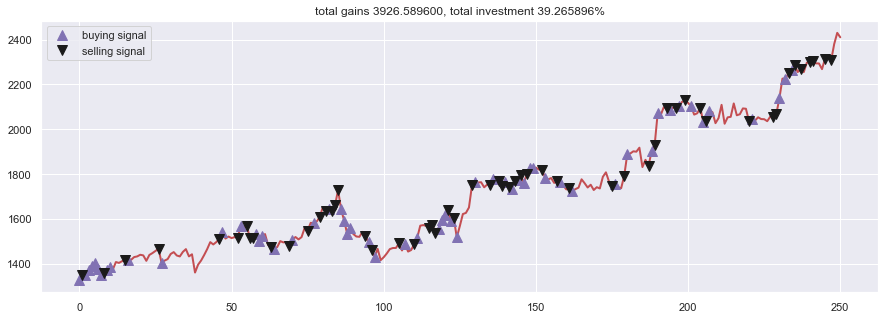

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()